Created by Ignacio Oguiza - email: oguiza@gmail.com

Modified by @pomo (Malcolm McLean) to handle variable length timeseries

This version posted 20200405

In [1]:
# Attempt to diagnose a CUDA error...
# from os import environ
# environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
device = 'cuda'
from ROCKETfuncs.ROCKETSound1 import *
from sklearn.linear_model import RidgeClassifierCV
print('pytorch:', torch.__version__)

pytorch: 1.4.0


In [4]:
import matplotlib.pyplot as plt
import pathlib
from os import path
HOME = pathlib.Path(path.expanduser("~"))
DATA = pathlib.Path('data')
from IPython.display import Audio # Audio(wav_files[1])

In [5]:
#My own utility for staying oriented!
from myUtils.showType import ShowType
t = ShowType().type_str
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

### 1️⃣ Generate features

First you prepare the input data and normalize it per sample. The input to ROCKET Pytorch is a 3d tensor (preferrable on gpu)

In [6]:
#Load Macaque calls and name that were saved in a different notebook...
callArray = np.load(HOME/'.fastai/data/macaques_24414Hz/callArray.npy', allow_pickle=True) #This half-baked interpreter won't use ~ for Home.
t(callArray)

'ndarray[7285]<object>'

In [7]:
nameArray = np.load(HOME/'.fastai/data/macaques_24414Hz/nameArray.npy', allow_pickle=True)
t(nameArray)

'ndarray[7285]<<U2>'

In [8]:
#Normalize waveforms to mean 0, std 1
def npM0S1(x):
    return (x-x.mean())/(x.std())  #No /0 danger for these samples: min([c.std() for c in callArray])

for i,x in enumerate(callArray):
    callArray[i] = npM0S1(x)

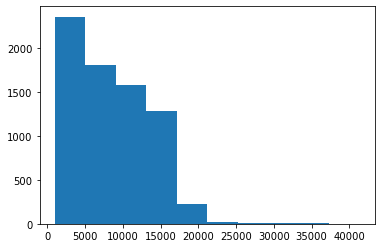

In [9]:
#Take a look at the distribution of sample lengths...
_=plt.hist(([len(x) for x in callArray]))

In [10]:
# Place calls in array, padded with nan on right, sized to the longest sample.
outarr=np.zeros((np.max([len(ps) for ps in callArray]),len(callArray)), dtype=np.float32)*np.nan 
for i,c in enumerate(callArray):  #populate columns
    outarr[:len(c),i]=c

In [11]:
#Format samples for nn.conv1d...
tcalls = torch.tensor(outarr).transpose(0,1).unsqueeze(1)
t(tcalls)

'Tensor(cpu)[7285, 1, 41307]<float32>'

In [12]:
# #Uncomment this cell to cut down to a small number of samples for testing.

# ncut = 500  #Use this many samples.

# ndx = torch.randperm(len(tcalls)).tolist()
# tcalls = tcalls[ndx]
# tcalls = tcalls[:ncut]

# nameArray = nameArray[ndx]
# nameArray = nameArray[:ncut]
# t(tcalls),t(nameArray)

In [13]:
#Randomize, split into training and validation sets, load audio samples to device.
trainFrac = .8
nt = int(trainFrac*len(tcalls))

indices = torch.randperm(len(tcalls)).tolist()
X_train = tcalls[indices][:nt,:,:].to(device)
X_valid = tcalls[indices][nt:,:,:].to(device)

y_train = nameArray[indices][:nt]
y_valid = nameArray[indices][nt:]

t(X_train),t(X_valid),t(y_train),t(y_valid)

('Tensor(cuda:0)[5828, 1, 41307]<float32>',
 'Tensor(cuda:0)[1457, 1, 41307]<float32>',
 'ndarray[5828]<<U2>',
 'ndarray[1457]<<U2>')

In [14]:
#Sort input and target ascending by length of audio. 
#This greatly speeds up the generation of ROCKET features (see below).
def sortSet(inp,target):
    lengths = torch.isfinite(inp).sum(dim=-1).squeeze() #Number of non-nans is the sample length
    sortIndex = lengths.argsort()   
    return inp[sortIndex],target[sortIndex.cpu()]

X_train,y_train = sortSet(X_train,y_train)
X_valid,y_valid = sortSet(X_valid,y_valid)

In [15]:
#Save in case we want to reproduce this train/val split
torch.save(X_train,DATA/'X_train')
torch.save(y_train,DATA/'y_train')
torch.save(X_valid,DATA/'X_valid')
torch.save(y_valid,DATA/'y_valid')

In [16]:
n_kernels=1000    #10000 is typical. 1000 performs a bit worse but is 10x faster to calculate.
kss=[7, 9, 11]
nfeatures = X_train.shape[1]

In [17]:
#There's a choice here. 
# 1) Tell ROCKET that the sequence length is as long as the longest call. 
# Then it generates conv1d's with large dilations that will be truncated or empty for shorter samples.
# I think this means that ROCKET will not see low-frequency patterns.

# 2) Tell ROCKET the sequence length is as long as the shortest sample. In this case, dilations are smaller, and low frequencies may be invisible.
# But the features calculate much faster, and nn.conv1d stops throwing exception that have to be caught.
# In actual testing, #2 does just as well or better.

# seq_len = X_train.shape[2]  # 1)
seq_len = min(torch.isfinite(X_train).sum(dim=-1).squeeze().min(),torch.isfinite(X_valid).sum(dim=-1).squeeze().min()).item()  #2)

#N.B. When #1 is chosen, default values must be used when the sample is too short for a conv1d to return any values.
#The particular choice of these defaults seems to affect accuracy.
#When #2 is chosen, the conv1d's can handle all samples. The default values do not matter.

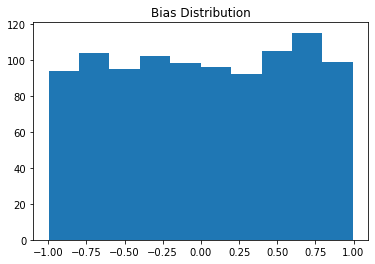

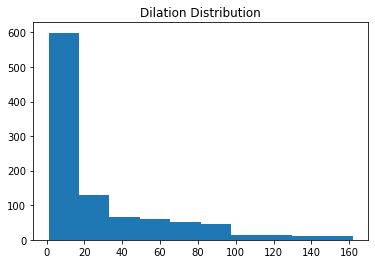

In [18]:
model = ROCKET(nfeatures, seq_len, n_kernels=n_kernels, kss=kss).to(device)  #Generate conv1d's

#Let's plot bias and dilation distributions...
dilations = [c.dilation[0] for c in model.convs]
biases = [c.bias.data.item() for c in model.convs]
plt.hist(biases)
plt.title('Bias Distribution')
plt.show()
plt.hist(dilations)
_ = plt.title('Dilation Distribution')

In [19]:
#Generate ROCKET features from the samples.
#Use smaller batches to prevent CUDA out of memory.

bs = 500

def makeTfm(da,bs):
#we assume that da is sorted by sample length ascending!

    nBatches = (len(da)//bs)+1
    for bi in range(nBatches):
        end = min(bi*bs+bs,len(da))
        batch = da[bi*bs:end] 
        if len(batch)==0:
            break;

        maxlength = torch.isfinite(batch[-1,0,:]).sum()  #Max length of the samples in this batch is length of the last sample
        
        bp = batch[:,:,:maxlength]                       #Process the shortest possible batch length to save time
        print(bi+1,'/',nBatches,'  batch =',t(bp))
        btfm = model(bp)           
        if (bi==0):
            tfm = btfm
        else:
            tfm = torch.cat((tfm,btfm), 0) 
    return tfm

In [20]:
X_train_tfm = makeTfm(X_train,bs)
t(X_train_tfm)

1 / 12   batch = Tensor(cuda:0)[500, 1, 2695]<float32>
2 / 12   batch = Tensor(cuda:0)[500, 1, 3471]<float32>
3 / 12   batch = Tensor(cuda:0)[500, 1, 4226]<float32>
4 / 12   batch = Tensor(cuda:0)[500, 1, 5274]<float32>
5 / 12   batch = Tensor(cuda:0)[500, 1, 6721]<float32>
6 / 12   batch = Tensor(cuda:0)[500, 1, 8117]<float32>
7 / 12   batch = Tensor(cuda:0)[500, 1, 9580]<float32>
8 / 12   batch = Tensor(cuda:0)[500, 1, 11195]<float32>
9 / 12   batch = Tensor(cuda:0)[500, 1, 12872]<float32>
10 / 12   batch = Tensor(cuda:0)[500, 1, 14477]<float32>
11 / 12   batch = Tensor(cuda:0)[500, 1, 16421]<float32>
12 / 12   batch = Tensor(cuda:0)[328, 1, 41307]<float32>


'Tensor(cuda:0)[5828, 2000]<float32>'

In [21]:
X_valid_tfm = makeTfm(X_valid,bs)
t(X_valid_tfm)

1 / 3   batch = Tensor(cuda:0)[500, 1, 5464]<float32>
2 / 3   batch = Tensor(cuda:0)[500, 1, 11119]<float32>
3 / 3   batch = Tensor(cuda:0)[457, 1, 35020]<float32>


'Tensor(cuda:0)[1457, 2000]<float32>'

In [22]:
# #Any nans or infs among the features? Success if none!
# (~torch.isfinite(X_train_tfm)).sum().item(),(~torch.isfinite(X_valid_tfm)).sum().item()

In [23]:
#Save these expensive features.
torch.save(X_train_tfm,DATA/'X_train_tfm')
torch.save(X_valid_tfm,DATA/'X_valid_tfm')

In [24]:
# #Reload features later without recalculating.
# X_valid_tfm = torch.load(DATA/'X_valid_tfm').to(device)
# X_train_tfm = torch.load(DATA/'X_train_tfm').to(device)
# X_train = torch.load(DATA/'X_train')
# y_train = torch.load(DATA/'y_train')
# X_valid = torch.load(DATA/'X_valid')
# y_valid = torch.load(DATA/'y_valid')

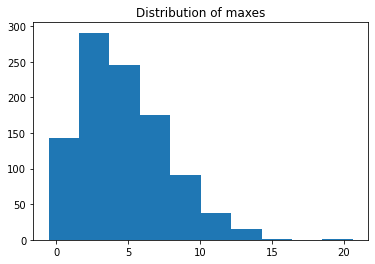

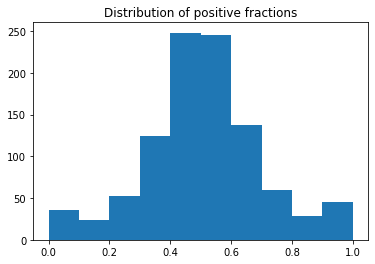

In [25]:
callN = 12  #Visualize the features of this one sound sample.
plt.hist(X_train_tfm.cpu()[callN,0::2])
plt.title('Distribution of maxes')
plt.show()

plt.hist(X_train_tfm.cpu()[callN,1::2])
plt.title('Distribution of positive fractions')
plt.show()

In [26]:
# # Appending the call length as an extra feature does NOT help accuracy.
# L_train = np.array([torch.isfinite(c).sum().item() for c in X_train])
# L_valid = np.array([torch.isfinite(c).sum().item() for c in X_valid])
# L_train = npM0S1(L_train)
# L_valid = npM0S1(L_valid)
# X_train_tfm = torch.cat((X_train_tfm,torch.cuda.FloatTensor(L_train).unsqueeze(1)), dim=1)
# X_valid_tfm = torch.cat((X_valid_tfm,torch.cuda.FloatTensor(L_valid).unsqueeze(1)), dim=1)
# t(X_train_tfm)

### 2️⃣ Apply a classifier

#### RidgeClassifierCV

And now you apply a classifier of your choice. 
With RidgeClassifierCV in particular, there's no need to normalize the calculated features before passing them to the classifier, as it does it internally (if normalize is set to True as recommended by the authors).

In [27]:
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True, fit_intercept=True)
ridge.fit(X_train_tfm.cpu(), y_train)

print('alpha: {:.2E}  train: {:.5f}  valid: {:.5f}'.format(ridge.alpha_, 
                                                           ridge.score(X_train_tfm.cpu(), y_train[:len(X_train_tfm)]), 
                                                           ridge.score(X_valid_tfm.cpu(), y_valid[:len(X_valid_tfm)])))

alpha: 1.00E-02  train: 0.97872  valid: 0.96019


In [28]:
#Convert the two letter labels into integers that PyTorch can use. Place on device.
unames,y_trainN = np.unique(y_train, return_inverse=True)
unames,y_validN = np.unique(y_valid, return_inverse=True)

ttargets = torch.cuda.LongTensor(y_trainN).to(device)
vtargets = torch.cuda.LongTensor(y_validN).to(device)

In [29]:
# Normalize inputs per feature.
# I don't think it's understood why this helps, but it does empirically.
# In this particular example, it adds about 1% to the accuracy.
f_mean = X_train_tfm.mean(dim=0, keepdims=True)
f_std = X_train_tfm.std(dim=0, keepdims=True) +1e-6

X_train_tfm = (X_train_tfm - f_mean) / f_std
X_valid_tfm = (X_valid_tfm - f_mean) / f_std

In [30]:
#The model is simply one Linear layer with weights and biases.
trainModel = nn.Sequential(nn.Linear(X_train_tfm.shape[-1],len(unames))).cuda()

import torch.optim as optim 

# optimizer = optim.Adam(trainModel.parameters(), lr=.005, weight_decay=0)?
optimizer = optim.SGD(trainModel.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [31]:
# PyTorch training loop.

print('epoch   training loss   train accuracy  validation loss    valid accuracy')
for epoch in range(10001):  # loop over the dataset multiple times
    optimizer.zero_grad()

    # forward + backward + step
    tpreds = trainModel(X_train_tfm)
    tloss = loss_fn(tpreds, ttargets)
    with torch.no_grad():
        vpreds = trainModel(X_valid_tfm)
        vloss = loss_fn(vpreds, vtargets)
    if epoch%200 == 0:
        print(epoch,tloss.item(),accuracyCopy(tpreds,ttargets).item(),vloss.item(), accuracyCopy(vpreds,vtargets).item())
    tloss.backward()
    optimizer.step()

epoch   training loss   train accuracy  validation loss    valid accuracy
0 2.305133581161499 0.08150308579206467 2.2927215099334717 0.08510638028383255
200 0.27223441004753113 0.9138640761375427 0.3123724162578583 0.9039121270179749
400 0.22141903638839722 0.9301646947860718 0.26923468708992004 0.9196979999542236
600 0.1944897621870041 0.9414893388748169 0.24668945372104645 0.9320521354675293
800 0.17667122185230255 0.9468084573745728 0.231561541557312 0.9327384829521179
1000 0.16354061663150787 0.951956033706665 0.22026850283145905 0.9347975254058838
1200 0.1532295197248459 0.9555593729019165 0.21132679283618927 0.9368565082550049
1400 0.14479172229766846 0.9581331014633179 0.2039727419614792 0.9375428557395935
1600 0.13768614828586578 0.9596773982048035 0.19776062667369843 0.940288245677948
1800 0.13157491385936737 0.9627659320831299 0.19240802526474 0.9396018981933594
2000 0.12623237073421478 0.9643102288246155 0.18772488832473755 0.940288245677948
2200 0.12150037288665771 0.964653

In [32]:
w = trainModel[0].weight.data
wsave = w.clone()  #Save a copy in case of screw ups.

# w = torch.tensor(ridge.coef_)  #Alternatively, use the weights that the RidgeClassifier found.

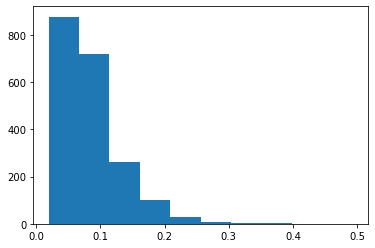

In [33]:
#This plot suggests that many of the ROCKET features are not used for classification.
#What if the unused features were removed, or replaced by other random conv1d's?
_ = plt.hist(w.norm(dim=0).cpu())

In [34]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [41]:
class ROCKETDataset(Dataset):
    def __init__(self, audioFeatures, labels):
        self.audioFeatures = audioFeatures
        self.labels = labels
 
    def __len__(self):
        return len(self.audioFeatures)

    def __getitem__(self, idx):
        return self.audioFeatures[idx],self.labels[idx]

#I defined this "attribute" only to work around an error thrown by fastai.
#I cannot figure out what fastai is trying to do.
    def init_kwargs(self):
        pass

In [42]:
trainDS = ROCKETDataset(X_train_tfm,ttargets)
validDS = ROCKETDataset(X_valid_tfm,vtargets)
# trainDS = TensorDataset(X_train_tfm,ttargets)  #PyTorch utility for handling this exact situation.
# validDS = TensorDataset(X_valid_tfm,vtargets)

In [43]:
# My GPU can handle the whole epoch at once, thus the full batch size.
trainDL = DataLoader(trainDS, batch_size=len(trainDS), shuffle=True, num_workers=0, pin_memory=False)
validDL = DataLoader(validDS, batch_size=len(validDS), shuffle=True, num_workers=0, pin_memory=False)

In [44]:
# Works?
for tbatch,ttarget in trainDL:
    print(t(tbatch),t(ttarget))
for vbatch,vtarget in validDL:
    print(t(vbatch),t(vtarget))

Tensor(cuda:0)[5828, 2000]<float32> Tensor(cuda:0)[5828]<int64>
Tensor(cuda:0)[1457, 2000]<float32> Tensor(cuda:0)[1457]<int64>


In [45]:
from fastai.basics import *
data = DataBunch(trainDL,validDL)  # Fails unless init_kwargs(self) is defined in the DataSet.
learn = Learner(data, trainModel, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])

In [46]:
# # This code used to suppress the progress bar. Now throws error.
# from fastai.utils.mod_display import *
# with progress_disabled_ctx(learn) as learn:

In [47]:
    for i in range(1):
        learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,accuracy,time
0,0.058926,0.131031,0.960192,00:00
1,0.058836,0.130965,0.960192,00:00
2,0.058756,0.130901,0.960878,00:00
3,0.058679,0.130971,0.960192,00:00
4,0.058594,0.130859,0.959506,00:00
5,0.058508,0.130496,0.960192,00:00
6,0.058416,0.130208,0.960192,00:00
7,0.058320,0.130149,0.960192,00:00
8,0.058214,0.130283,0.960192,00:00
9,0.058101,0.130156,0.960192,00:00


In [ ]:
# The end. 97.3% accuracy for this run.